In [1]:
import tensorflow as tf
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report

print('TensorFlow', tf.__version__)

TensorFlow 2.0.0-beta0


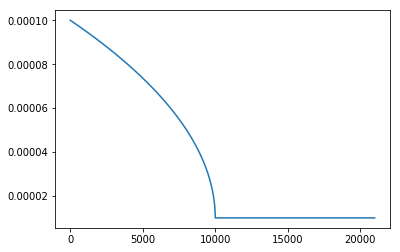

In [9]:
starter_learning_rate = 1e-4
end_learning_rate = 1e-5
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)
x = [learning_rate_fn(i).numpy() for i in range(21000)]
plt.plot(x)

In [ ]:
tf.distribute.experimental.MultiWorkerMirroredStrategy(communication=tf.distribute.experimental.CollectiveCommunication.RING)

In [2]:
def residual_block(input_tensor, block_type, n_filters):
    shortcut = input_tensor
    if block_type == 'conv':
        strides = 2
        shortcut =  tf.keras.layers.Conv2D(filters=n_filters, 
                                           kernel_size=1, 
                                           padding='same',
                                           strides=strides,
                                           kernel_initializer='he_normal', 
                                           use_bias=False,
                                           kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(shortcut)
        shortcut = tf.keras.layers.BatchNormalization(momentum=0.9)(shortcut)
        
    elif block_type == 'identity':
        strides = 1

    x = tf.keras.layers.Conv2D(filters=n_filters, 
                               kernel_size=3, 
                               padding='same',
                               strides=strides,
                               kernel_initializer='he_normal', 
                               use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(input_tensor)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters=n_filters, 
                               kernel_size=3, 
                               padding='same',
                               strides=1,
                               kernel_initializer='he_normal', 
                               use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x


def ResNet34(input_shape=[None, None, 3], num_classes=1000, include_top=True, return_endpoints=False):
    input_tensor = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=7, 
                               padding='same', 
                               strides=2, 
                               kernel_initializer='he_normal', 
                               use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(input_tensor)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(3, 2, padding='same')(x)
    
    for n_filters, reps, downscale in zip([64, 128, 256, 512], 
                                          [3, 4, 6, 3], 
                                          [False, True, True, True]):
        for i in range(reps):
            if i == 0 and downscale:
                x = residual_block(input_tensor=x, 
                                   block_type='conv', 
                                   n_filters=n_filters)
            else:
                x = residual_block(input_tensor=x, 
                                   block_type='identity', 
                                   n_filters=n_filters)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if include_top:
        x = tf.keras.layers.Dense(units=num_classes)(x)
    return tf.keras.Model(inputs=input_tensor, outputs=x, name='ResNet34')

In [3]:
H, W = 256, 256
classes = sorted(['n03417042', 'n03028079', 'n03888257', 'n02102040', 'n01440764', 'n03445777', 'n03000684', 'n02979186', 'n03394916', 'n03425413'])
label_map = {v:i for i, v in enumerate(classes)}

train_images = glob('imagenette/train/*/*')
np.random.shuffle(train_images)
train_labels = [label_map[x.split('/')[-2]] for x in train_images]

val_images = glob('imagenette/val/*/*')
np.random.shuffle(val_images)
val_labels = [label_map[x.split('/')[-2]] for x in val_images]

print('Number of classes : ', len(classes))
print('Found', len(train_images), 'train images')
print('Found', len(val_images), 'validation images')

Number of classes :  10
Found 12894 train images
Found 500 validation images


In [6]:
train_images = tf.random.shuffle(val_images).numpy()
train_labels = [label_map[x.decode().split('/')[-2]] for x in train_images]

In [6]:
bbox = tf.constant([0., 0., 1., 1.])
bbox = tf.reshape(bbox, shape=[-1, 1, 4])
channel_means =  tf.constant([103.939, 116.779, 123.68])

def get_image(image_path, H=H, W=W):
    with tf.device('/cpu:0'):
        img = tf.io.read_file(image_path)
        sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        tf.image.extract_jpeg_shape(img),
        bounding_boxes=bbox,
        min_object_covered=0.1,
        aspect_ratio_range=[0.75, 1.33],
        area_range=[0.05, 1.0],
        max_attempts=100,
        use_image_if_no_bounding_boxes=True)
        bbox_begin, bbox_size, _ = sample_distorted_bounding_box

        offset_y, offset_x, _ = tf.unstack(bbox_begin)
        target_height, target_width, _ = tf.unstack(bbox_size)
        crop_window = tf.stack([offset_y, offset_x, target_height, target_width])

        cropped = tf.image.decode_and_crop_jpeg(
          img, crop_window, channels=3)
        cropped = tf.cast(cropped, dtype=tf.float32)
        cropped = tf.image.random_flip_left_right(cropped)
        cropped.set_shape([None, None, 3])            

        processed_image = tf.image.resize(cropped, size=[H, W], method='bilinear')
        processed_image = tf.clip_by_value(processed_image, 0, 255)
        processed_image  = processed_image[:,:,::-1] - channel_means
    return processed_image

def resize_preserve_aspect_ratio(image_tensor, min_side_dim=H):
    img_h, img_w = image_tensor.shape.as_list()[:2]
    min_dim = tf.minimum(img_h, img_w)
    resize_ratio = min_side_dim / min_dim
    new_h, new_w = resize_ratio * img_h, resize_ratio * img_w
    resized_image_tensor = tf.image.resize(image_tensor, size=[new_h, new_w])
    return resized_image_tensor
    
def get_image_eval(image_path, H=H, W=W):
    with tf.device('/cpu:0'):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = resize_preserve_aspect_ratio(img, min_side_dim=H)
        img = tf.image.resize_with_crop_or_pad(img, H, W)
        img  = img[:,:,::-1] - channel_means
    return img

def prepare_data(training=False):
    def load_data(image_path, label):
        if training:
            image = get_image(image_path)
        else:
            image = get_image_eval(image_path)
        return image, label
    return load_data

In [ ]:
batch_size = 32 * 3

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images) + 1)
train_dataset = train_dataset.apply(tf.data.experimental.map_and_batch(map_func=load_data, 
                                                   batch_size=batch_size, 
                                                   num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                                   drop_remainder=True))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.apply(tf.data.experimental.map_and_batch(map_func=load_data,
                                                   batch_size=batch_size, 
                                                   num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                                   drop_remainder=True))
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint('top_weights.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='val_sparse_categorical_accuracy'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', update_freq='batch')]

In [ ]:
starter_learning_rate = 1e-3
end_learning_rate = 5e-5
decay_steps = 60000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.8)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


strategy = tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1', '/gpu:2'])
with strategy.scope():
    model = ResNet34(input_shape=[H, W, 3], num_classes=10, include_top=True)
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=[tf.metrics.SparseCategoricalAccuracy()])
    
model.fit(train_dataset,
          steps_per_epoch=len(train_images) // batch_size,
          epochs=400,
          validation_data=val_dataset,
          validation_steps=len(val_images) // batch_size,
          callbacks=callbacks_list)
model.save_weights('last_epoch.h5')

In [8]:
#model = ResNet34(input_shape=[H, W, 3], num_classes=10, include_top=True)
model.load_weights('last_epoch.h5')

In [9]:
pred_labels = []
for image_path in tqdm_notebook(val_images):
    img = get_image_eval(image_path)
    img = tf.expand_dims(img, axis=0)
    logits = model(img)[0]
    label = tf.argmax(logits, axis=-1).numpy()
    pred_labels.append(label)
print(classification_report(val_labels, pred_labels))    


              precision    recall  f1-score   support

           0       0.96      0.94      0.95        50
           1       1.00      0.96      0.98        50
           2       0.94      0.94      0.94        50
           3       0.98      0.92      0.95        50
           4       0.82      0.94      0.88        50
           5       0.79      0.88      0.83        50
           6       0.92      0.96      0.94        50
           7       0.96      0.90      0.93        50
           8       0.98      0.86      0.91        50
           9       0.94      0.94      0.94        50

    accuracy                           0.92       500
   macro avg       0.93      0.92      0.93       500
weighted avg       0.93      0.92      0.93       500

